# Interactive Data Exploration
This notebook is for gaining some preliminary insight into the selected datasets we've chose to investigate. Our tentative
hypothesis is that there exists a largely positive correlation between investment grade corporate bond yields and the
treasury spread.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from utilities import filterout, normalize, get_common_dates


In [6]:
# Read in the data from CSV file
filenames = [ "TEDRATE","IG","HY","TB3","HY_yield"]

# Store each series in a mapping from filename to dataframe
dfs = {
    fn: pd.read_csv(f"./data/{fn}.csv", parse_dates=["DATE"]) for fn in filenames
}

# Filter out each non-numeric occurence in each series
for key in dfs:
    dfs[key] = filterout(dfs[key], key, ".")
    dfs[key][key] = pd.to_numeric(dfs[key][key])

# Get the intersection of the time series data relative to common dates
date_index = get_common_dates([dfs[key] for key in dfs],filenames)
common_date_dfs = {
    fn: dfs[fn][date_index[fn]] for fn in filenames
}

# Set the index of the dataframes to be the dates
for key in common_date_dfs.keys():
    common_date_dfs[key] = common_date_dfs[key].set_index("DATE")
    
# Normalized time series
normalized_series = {
    fn: normalize(common_date_dfs[fn][fn]) for fn in filenames
}

### Visualization of Normalized Time Series 

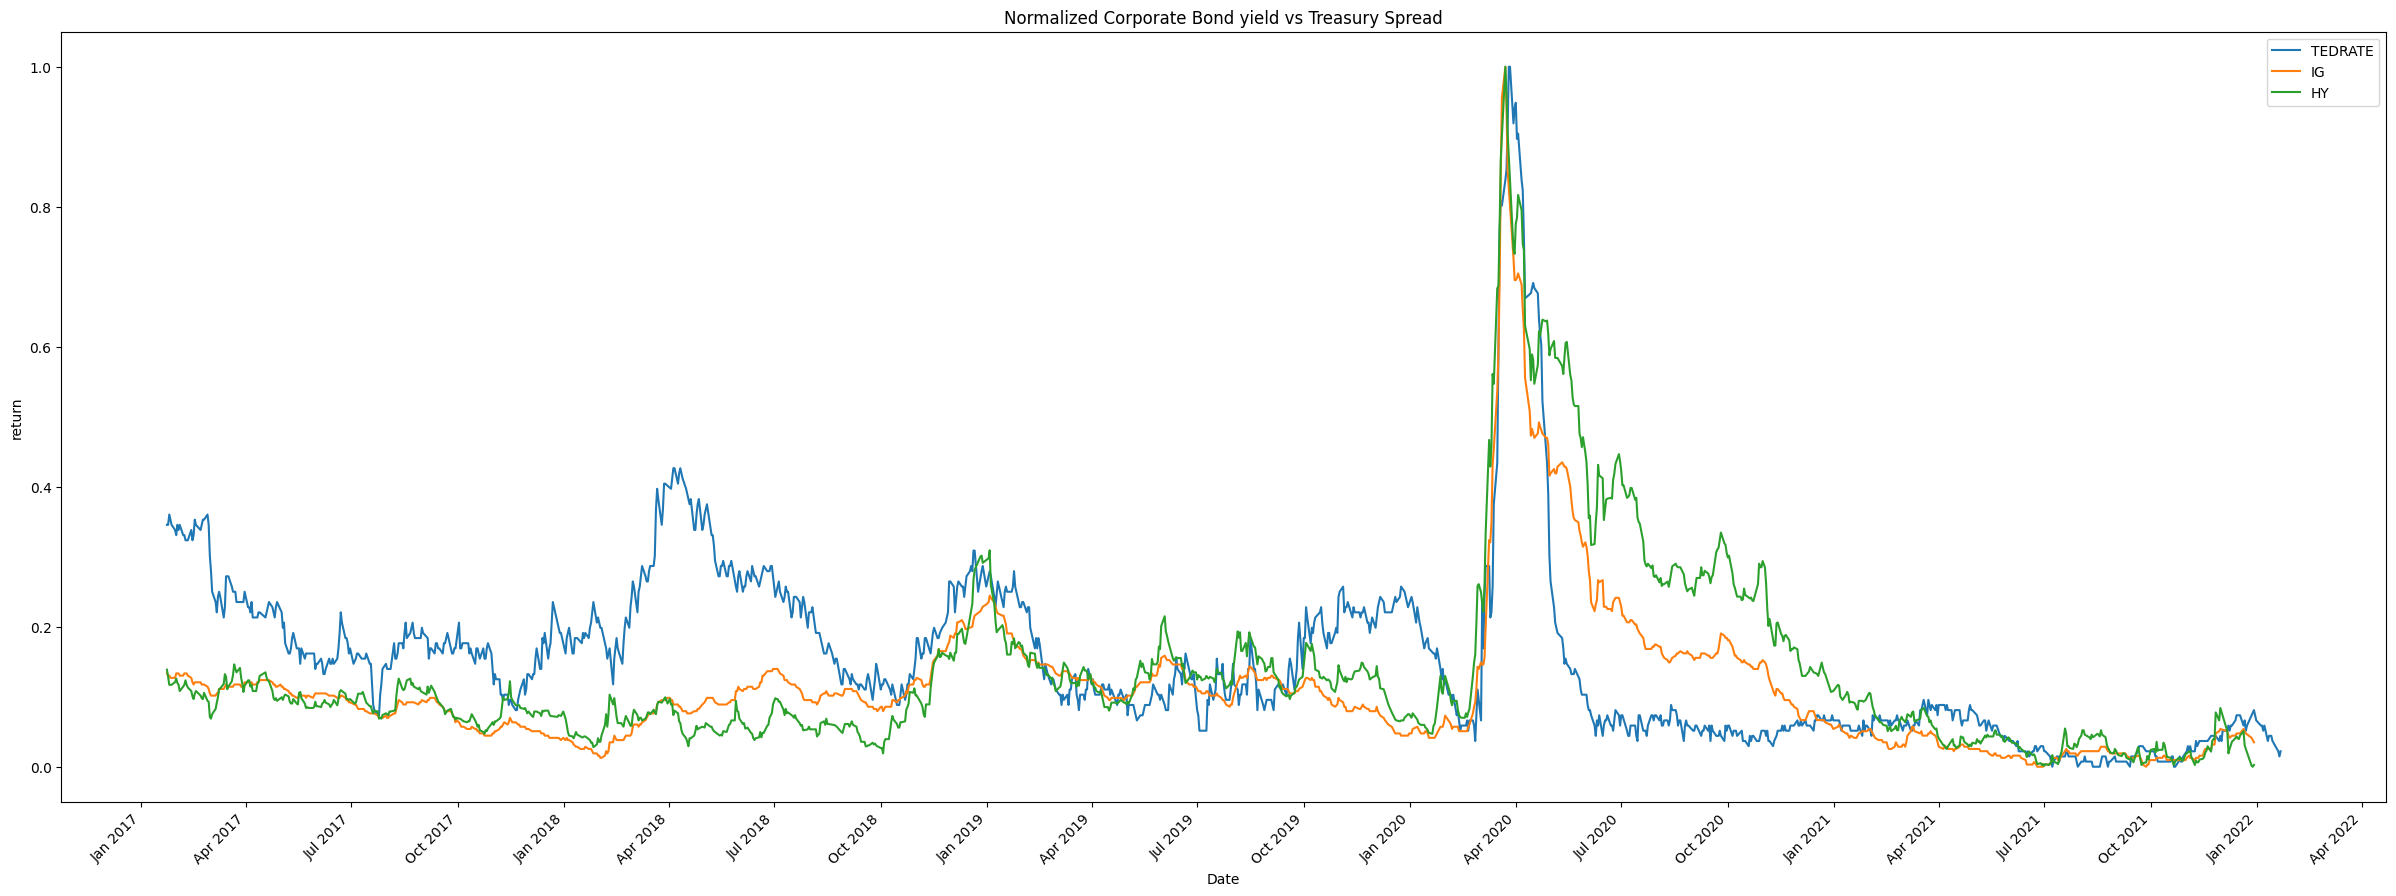

In [3]:
fig, ax = plt.subplots(figsize=(30, 10))
[ax.plot(common_date_dfs[label].index, ns, label=label) for label,ns in normalized_series.items()]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('return')
plt.title('Normalized Corporate Bond yield vs Treasury Spread')
plt.legend()
plt.show()


# Visualization of fourth root transformation

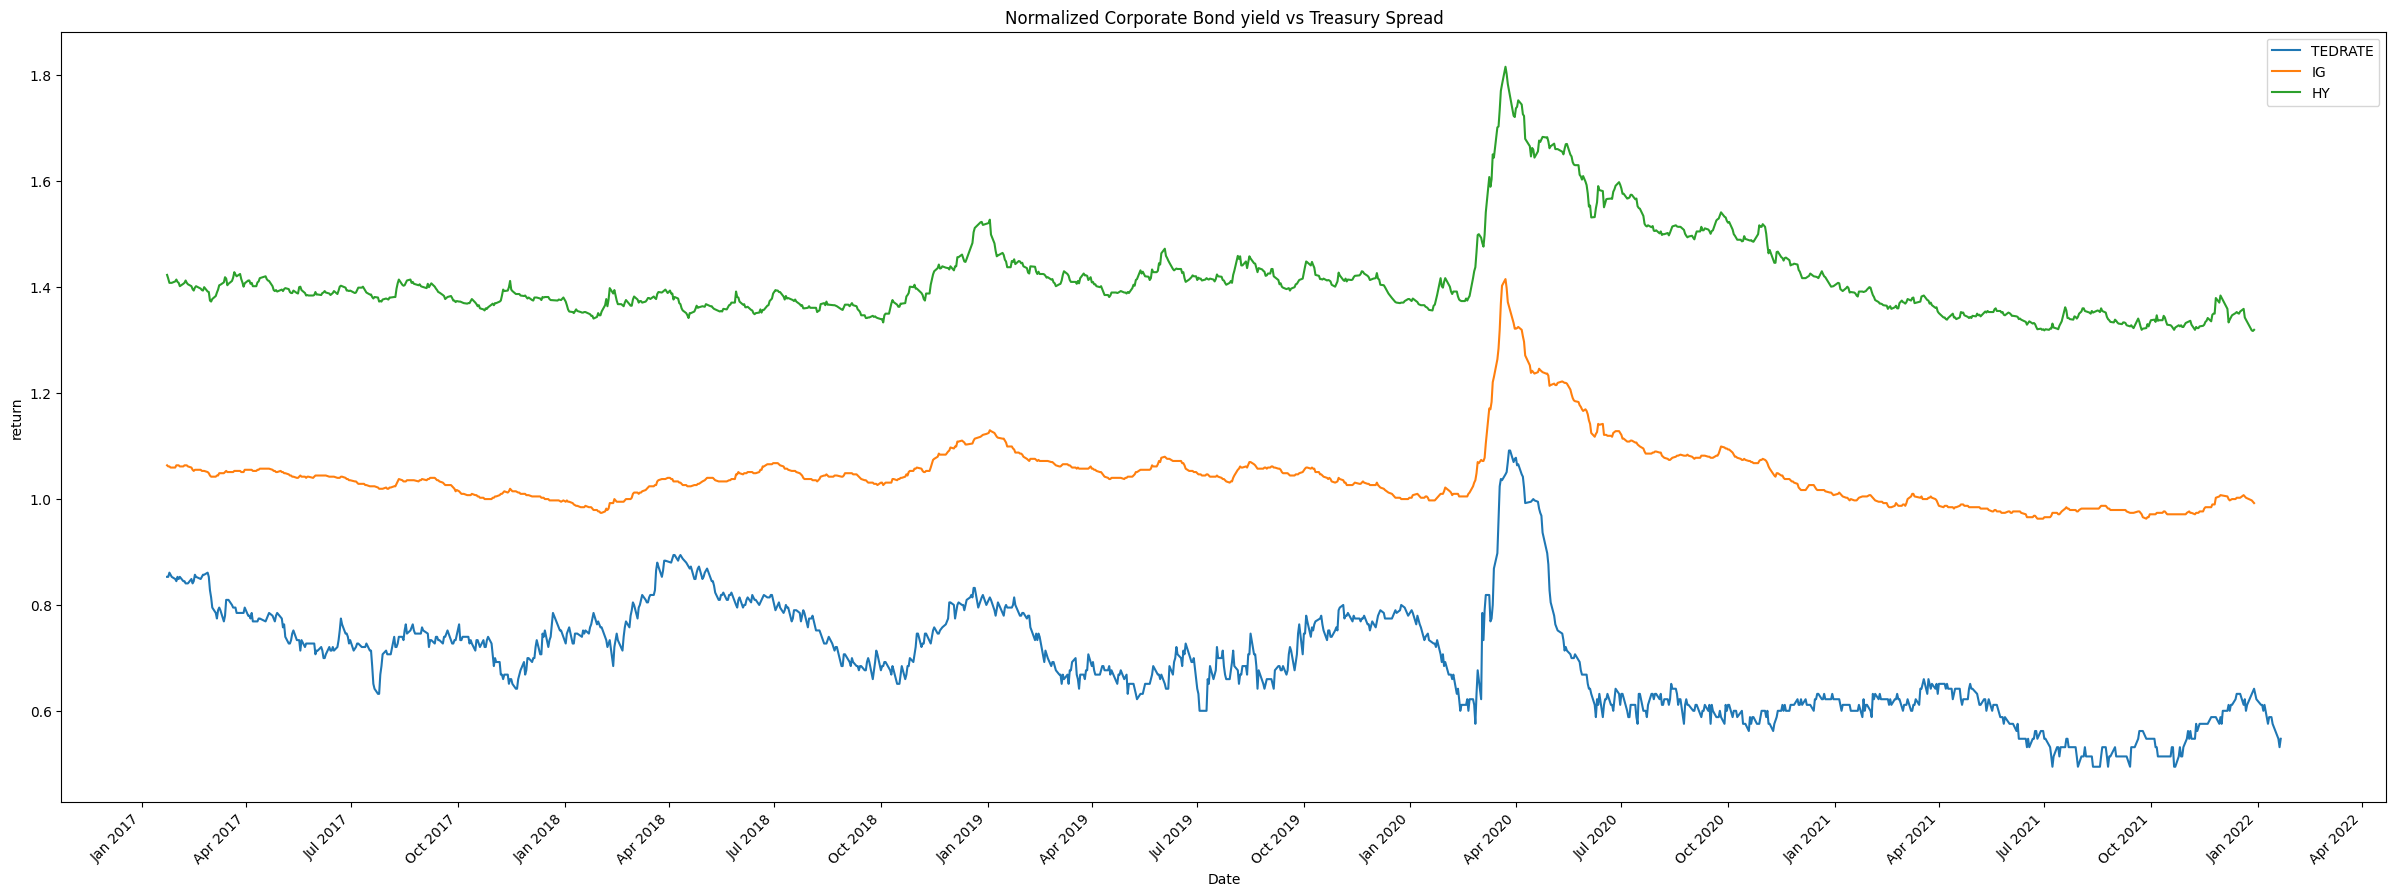

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))
[ax.plot(common_date_dfs[label].index, np.power(common_date_dfs[label],0.25), label=label) for label,ns in normalized_series.items()]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('return')
plt.title('Normalized Corporate Bond yield vs Treasury Spread')
plt.legend()
plt.show()

### Correlation as a Function of Window Length
We have a measure of the correlation between the two realizations of the underlying random variables that represent `DBAA` and `TEDRATE`. There is
largely a positive correlation, but what we seek to investigate now is correlation as a function of window length. Meaning, given some start date
and end date, what is the correlation over that interval.

In [4]:
max_window_size = len(common_date_dfs["DBAA"]["DBAA"].values)
corr_by_window = {ws:[] for ws in range(1, max_window_size + 1)}
window_size = 2

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        dbaa_slice = common_date_dfs["DBAA"]["DBAA"][beg_ndx:end_ndx]
        tedrate_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        corr_by_window[window_size].append(dbaa_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += 1

In [5]:
#replace nan values and convert list to array just in case
corr_by_window_sd = {ws:np.nan_to_num(np.array(corr_by_window[ws])) for ws in range(1, max_window_size + 1)}

In [6]:
 #take the mean of correlation for each window size
corr_by_window_mean =[np.mean(corr_by_window_sd[ws])for ws in range(2, max_window_size + 1)]
corr_by_window_max = [np.max(corr_by_window_sd[ws])for ws in range(2, max_window_size + 1)]

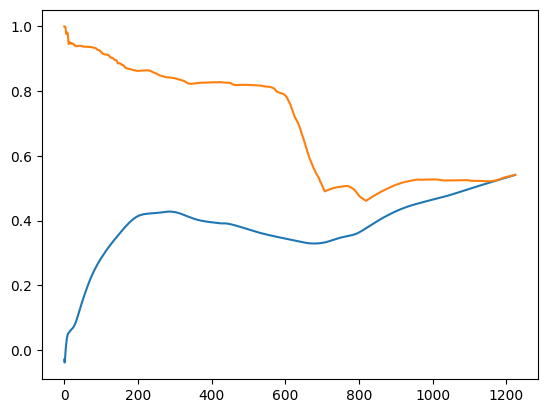

In [7]:
plt.plot(corr_by_window_mean)
plt.plot(corr_by_window_max)

Qualitatively it doens't really make a lot of sense to explore correlation longer than a reasonable time period, here 3 months is probably as long as it should go.

In [8]:
three_month_mean=[np.mean(corr_by_window_sd[ws])for ws in range(2, 90)]
three_month_max=[np.max(corr_by_window_sd[ws])for ws in range(2, 90)]

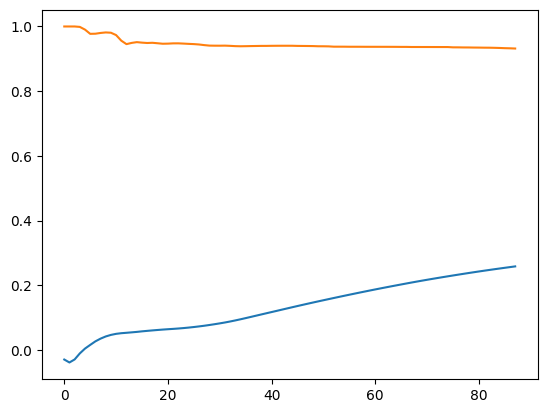

In [9]:
plt.plot(three_month_mean)
plt.plot(three_month_max)

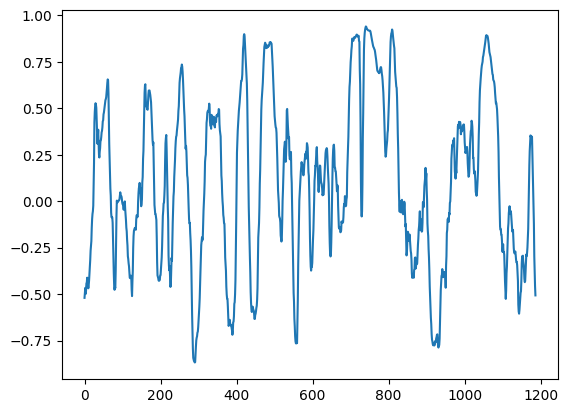

In [10]:
plt.plot(corr_by_window_sd[40])

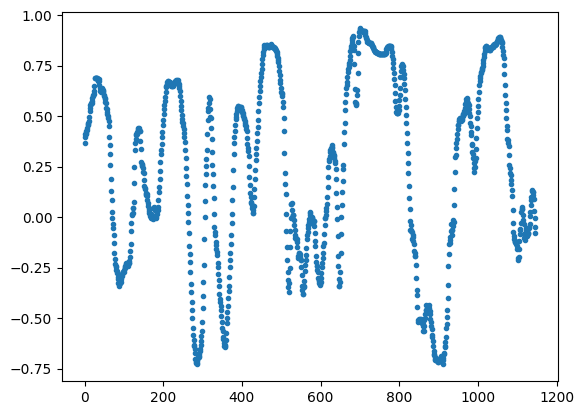

In [11]:
plt.plot(corr_by_window_sd[80],'.')

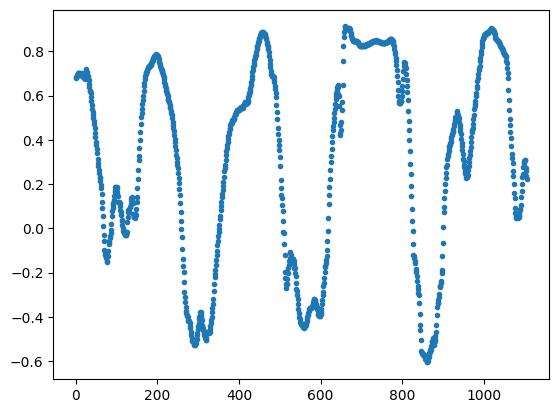

In [12]:
plt.plot(corr_by_window_sd[120],'.')

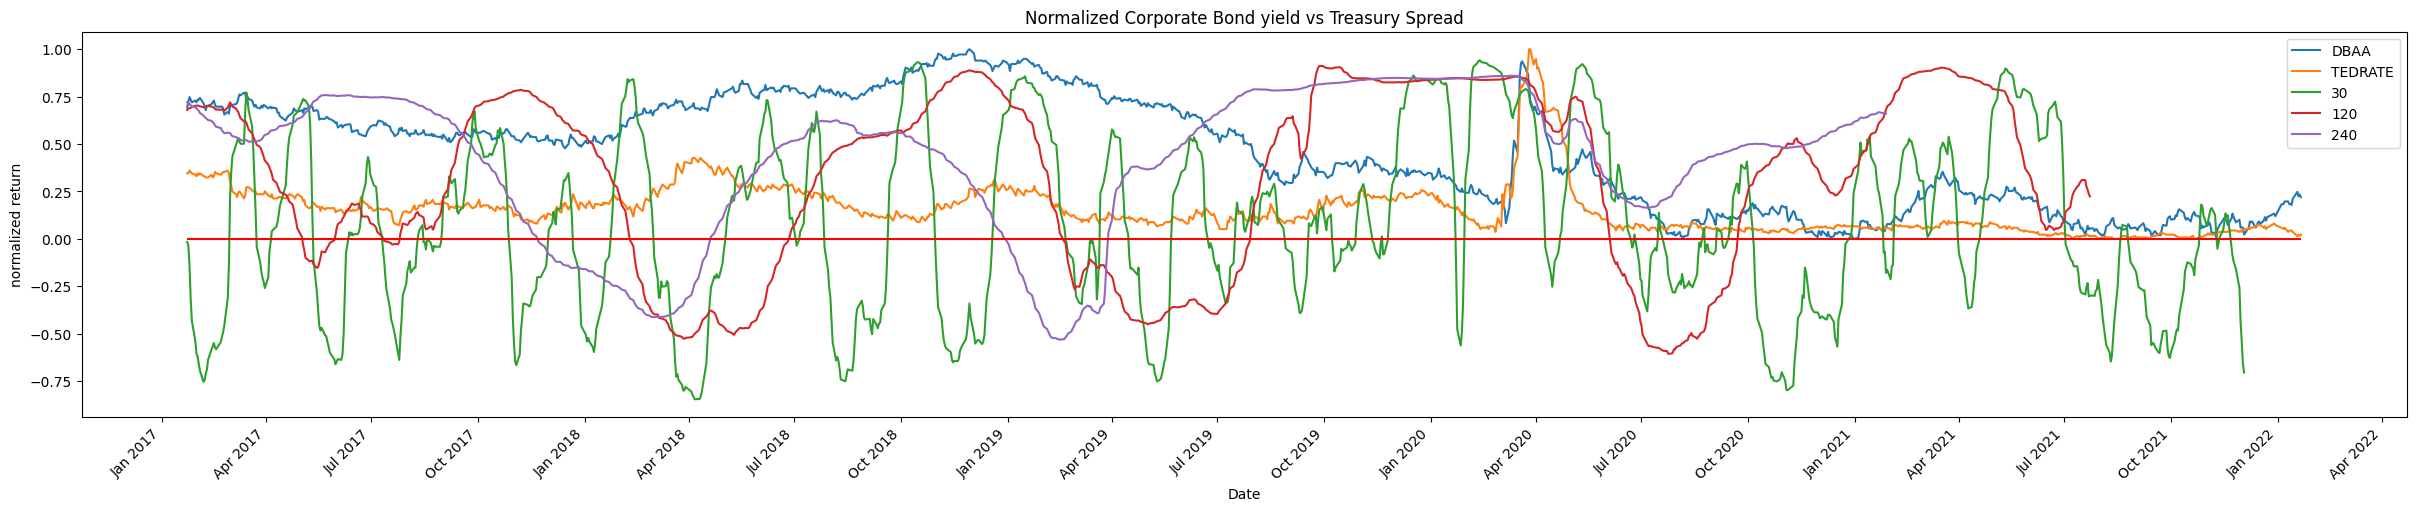

In [40]:
ws = [30, 120, 240]
fig, ax = plt.subplots(figsize=(30, 5))
[ax.plot(common_date_dfs[label].index, ns, label=label) for label, ns in normalized_series.items()]
[ax.plot(common_date_dfs["DBAA"].index[:len(corr_by_window[w])], corr_by_window[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["DBAA"].index[0], xmax=common_date_dfs["DBAA"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('normalized return')
plt.title('Normalized Corporate Bond yield vs Treasury Spread')
plt.legend()
plt.show()

# HY spread and TED spread

In [5]:
max_window_size = len(common_date_dfs['HY']['HY'].values)
step_size = 5
spread_corr_by_window = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY']['HY'][beg_ndx:end_ndx]
        tedrate_slice = common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx]
        spread_corr_by_window[window_size].append(hy_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Libra

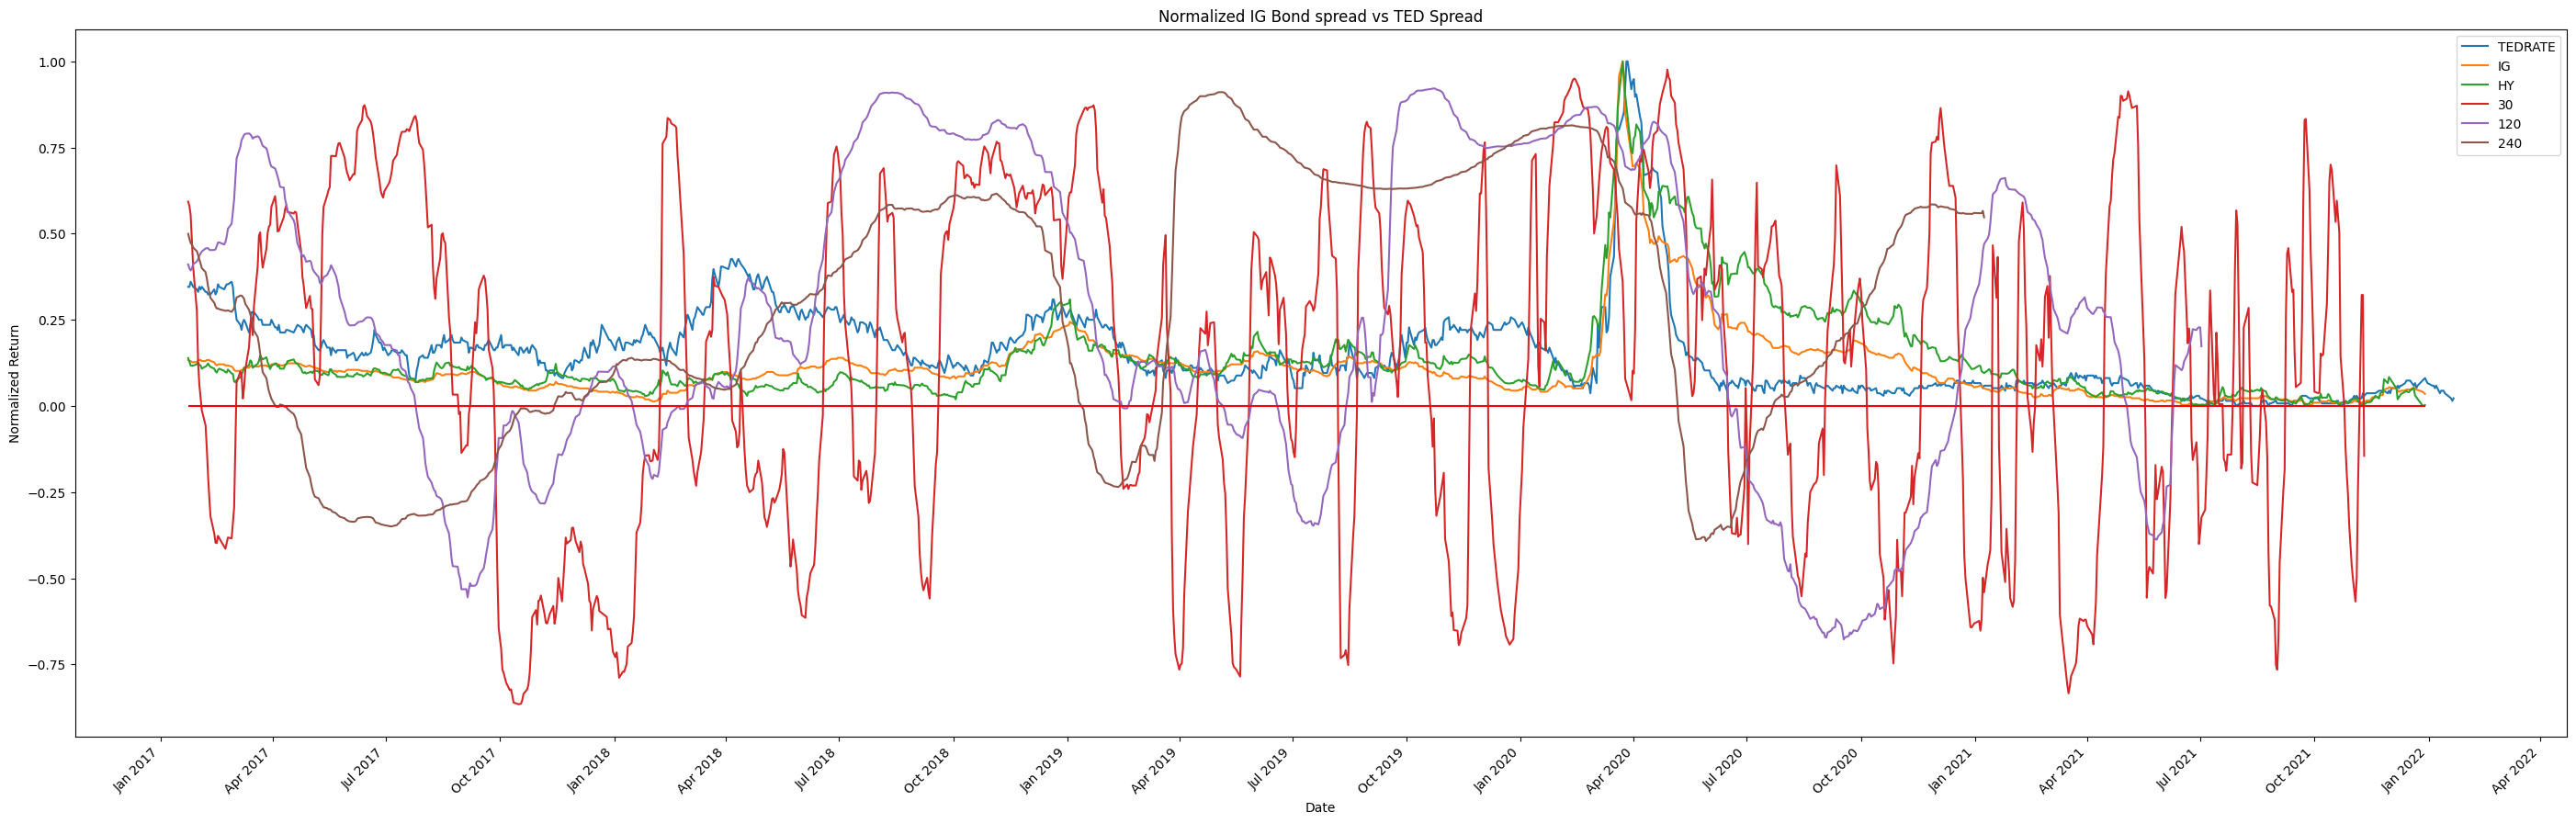

In [6]:
#plot of corr found on original data overlay normalized data
data=['HY','TEDRATE']
ws = [30, 120, 240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(spread_corr_by_window[w])], spread_corr_by_window[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

In [7]:
#correlation of the normalized series
# Iterate over all possible window sizes and collect correlation measures
step_size=5
norm_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = normalized_series['HY'][beg_ndx:end_ndx]
        tedrate_slice = normalized_series["TEDRATE"][beg_ndx:end_ndx]
        norm_corr[window_size].append(np.corrcoef(hy_slice,tedrate_slice,rowvar=False)[0][1])
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


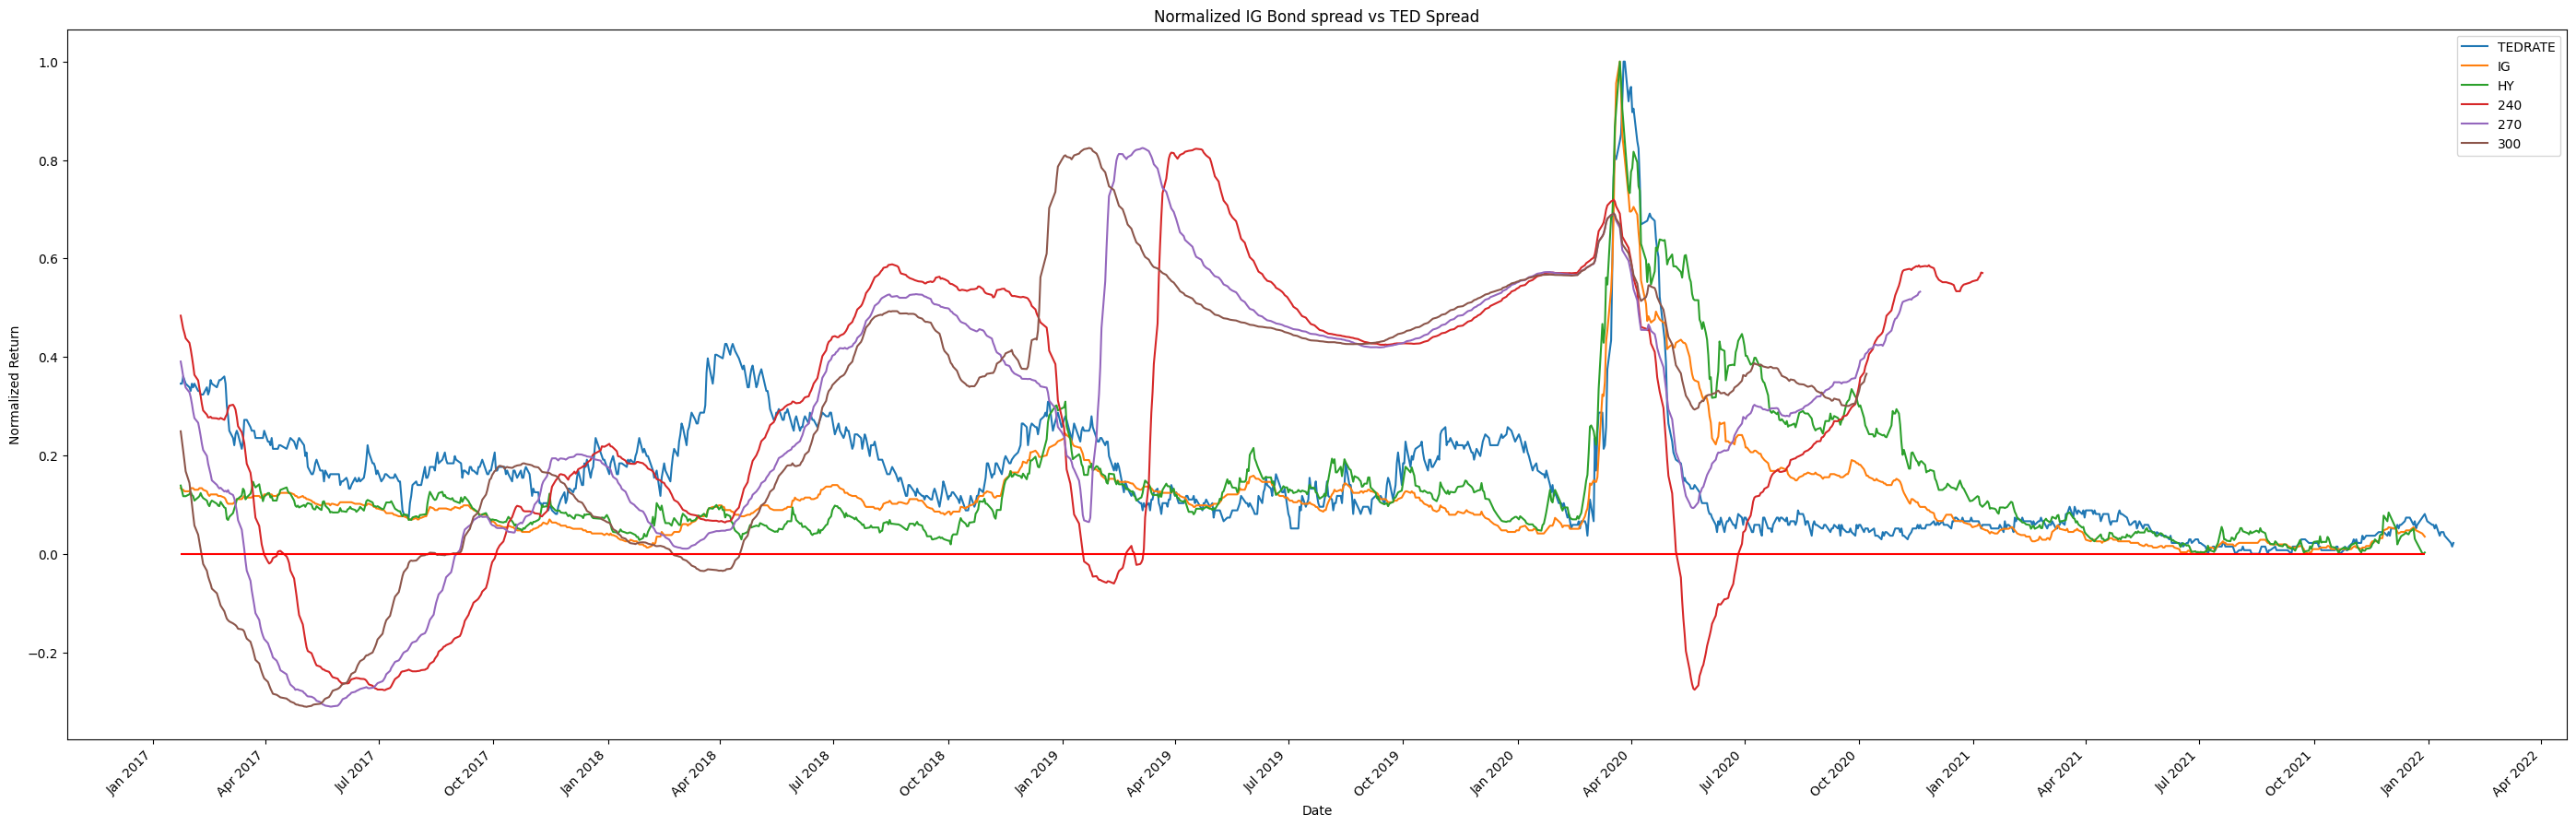

In [8]:
#plot of corr found on normalized data overlay normalized data
data=['HY','TEDRATE']
ws = [240,270,300]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], norm_corr[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

correlation of the normalized series is lower

In [9]:
#correlation of the fourth root
# Iterate over all possible window sizes and collect correlation measures
step_size=5
fourth_root_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = np.power(common_date_dfs['HY']['HY'][beg_ndx:end_ndx],3)
        tedrate_slice = np.power(common_date_dfs["TEDRATE"]["TEDRATE"][beg_ndx:end_ndx],3)
        fourth_root_corr[window_size].append(hy_slice.corr(tedrate_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Libra

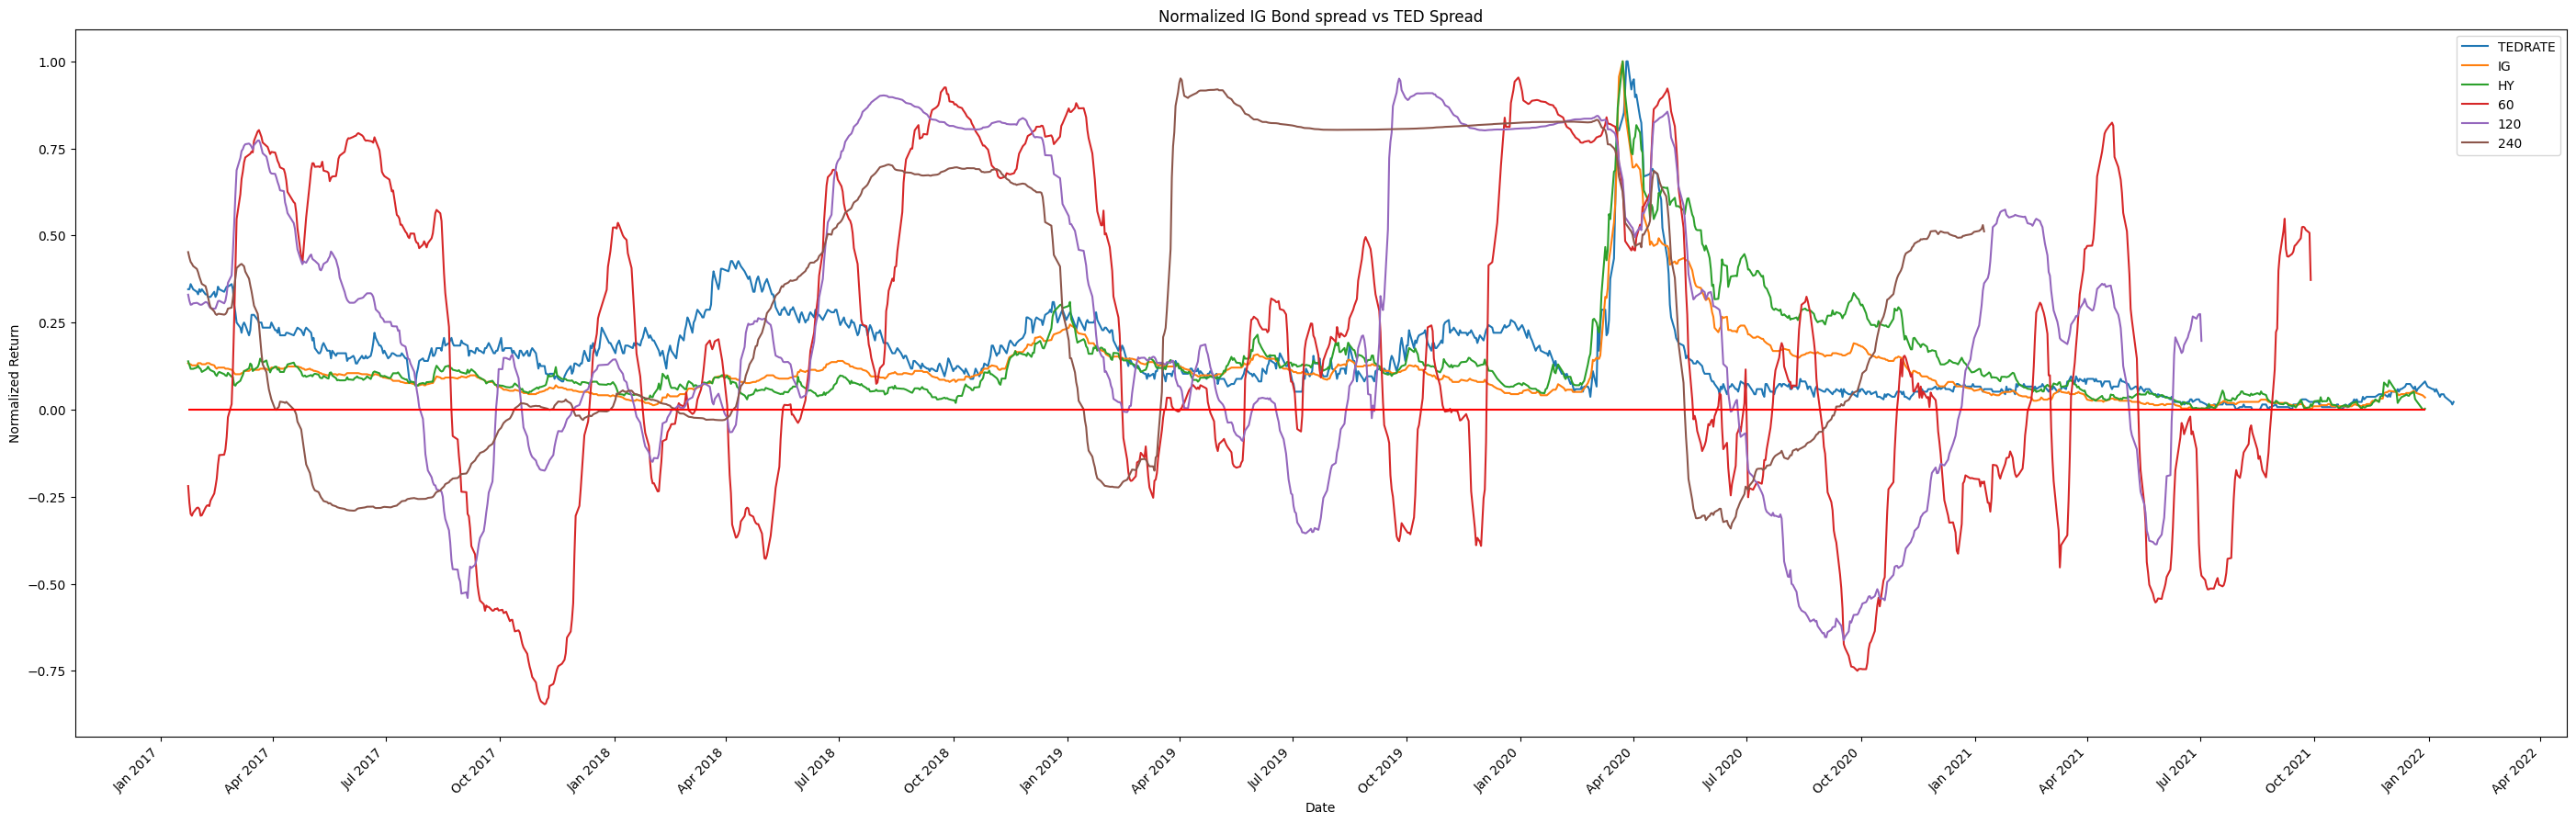

In [10]:
#plot of corr found on data cube overlay normalized data
#ignore the name...originally tryna find the fourth root one but realize that only makes corr smaller lol
data=['HY','TEDRATE']
ws = [60,120,240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], fourth_root_corr[w], label=f"{w}") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

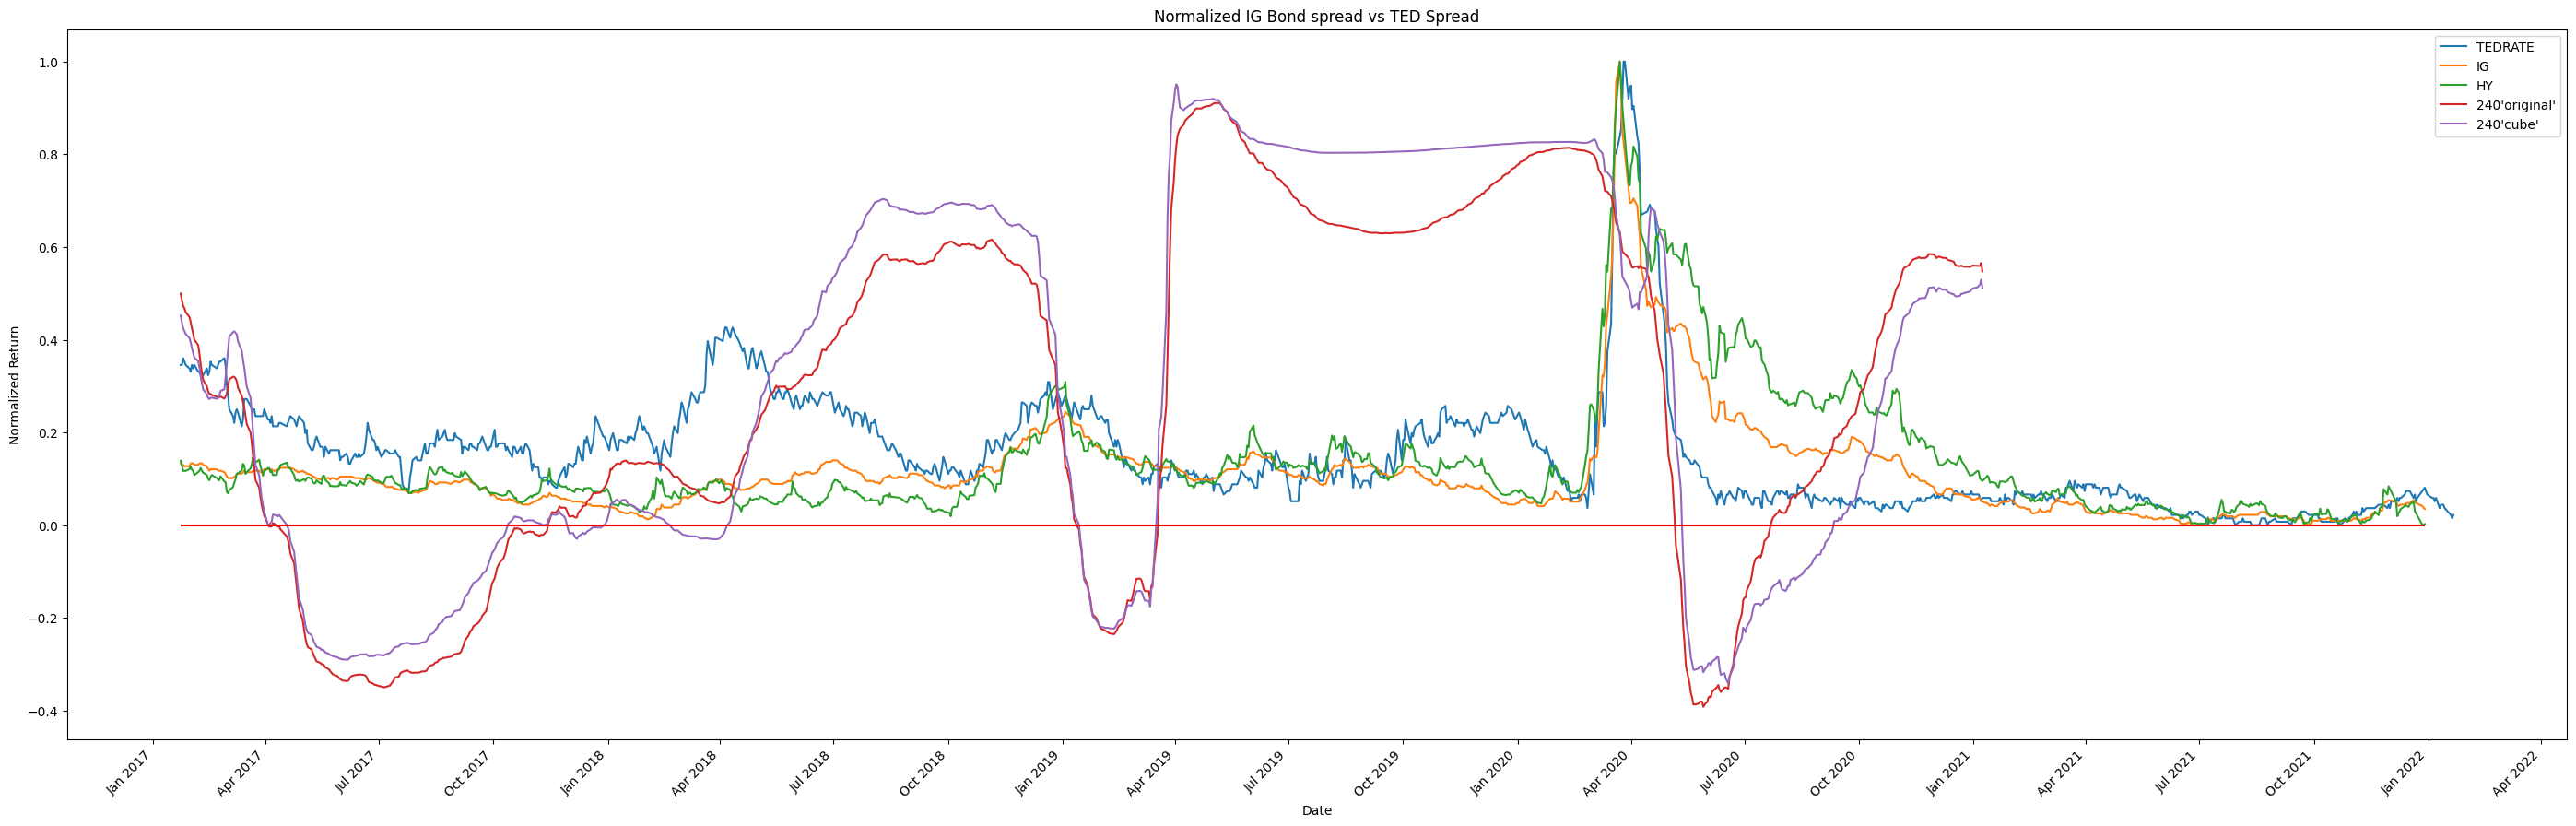

In [11]:
#compare the correlation of orignal data and cube
#plot of corr found on normalized data overlay normalized data
data=['HY','TEDRATE']
ws = [240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], spread_corr_by_window[w], label=f"{w}'original'") for w in ws]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], fourth_root_corr[w], label=f"{w}'cube'") for w in ws]
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

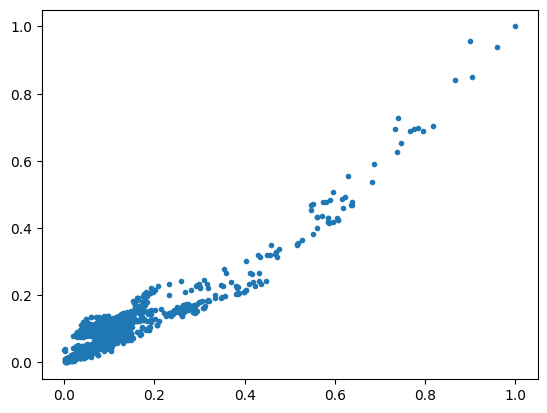

In [21]:
plt.plot(normalized_series['HY'],normalized_series['IG'],'.')

In [24]:
max_window_size = len(common_date_dfs['HY']['HY'].values)
step_size = 5
HY_IG_corr = {ws:[] for ws in range(5, max_window_size + 1,step_size)}
window_size = 5

# Iterate over all possible window sizes and collect correlation measures
while window_size <= max_window_size:
    beg_ndx = 0
    end_ndx = beg_ndx + window_size
    
    # Collect the correlation measures as we progress forward in time
    while end_ndx <= max_window_size:
        hy_slice = common_date_dfs['HY']['HY'][beg_ndx:end_ndx]
        ig_slice = common_date_dfs["IG"]["IG"][beg_ndx:end_ndx]
        HY_IG_corr[window_size].append(hy_slice.corr(ig_slice))
        
        beg_ndx += 1
        end_ndx += 1
    
    window_size += step_size

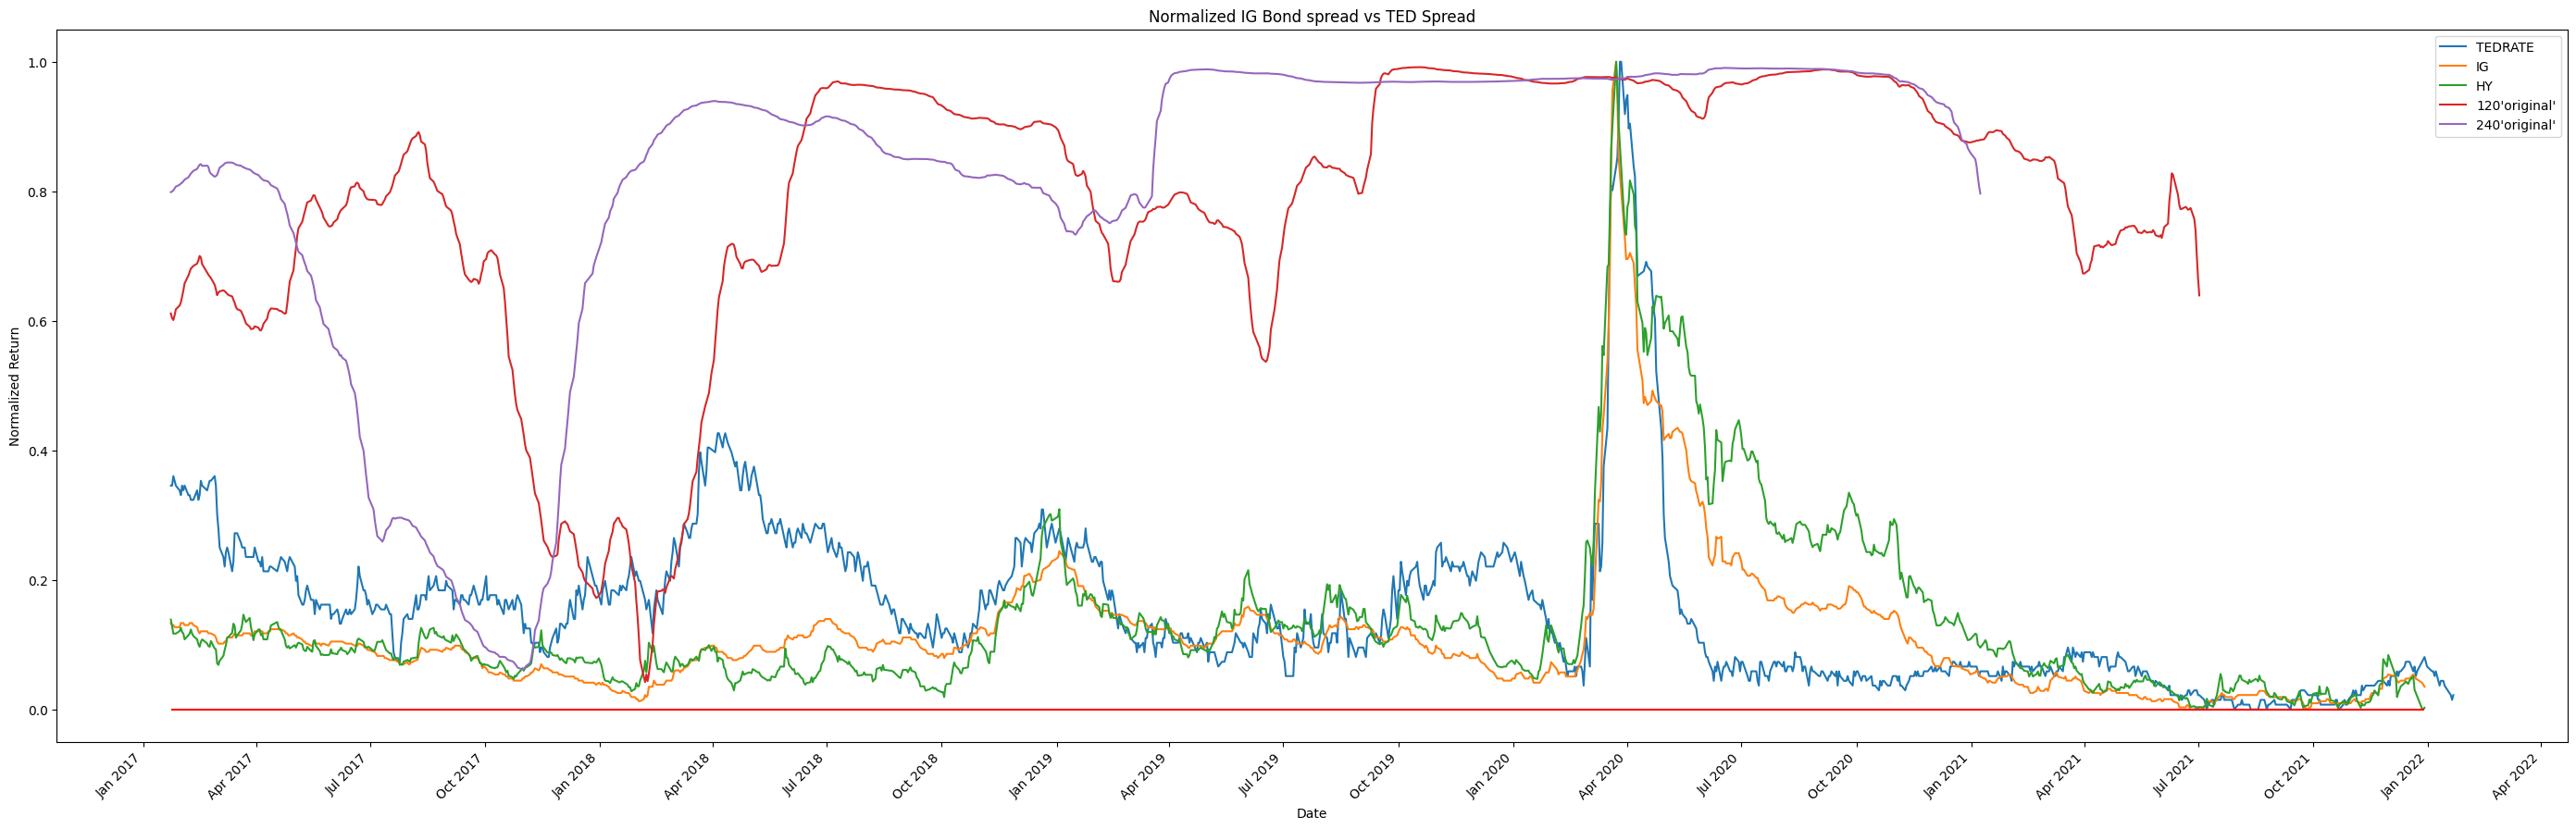

In [27]:
data=['HY','IG']
ws = [120,240]
fig, ax = plt.subplots(figsize=(35, 10))
[ax.plot(common_date_dfs[label].index,ns , label=label) for label,ns in normalized_series.items()]
[ax.plot(common_date_dfs["HY"].index[:len(norm_corr[w])], HY_IG_corr[w], label=f"{w}'original'") for w in ws]

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.hlines([0.], xmin=common_date_dfs["HY"].index[0], xmax=common_date_dfs["HY"].index[-1], color="red")
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.title('Normalized IG Bond spread vs TED Spread')
plt.legend()
plt.show()

# manually calculating spread

In [29]:
common_date_dfs.keys()

dict_keys(['TEDRATE', 'IG', 'HY', 'TB3', 'HY_yield'])

In [34]:
common_date_dfs['HY_spread'] = common_date_dfs['HY_yield']['HY_yield']-common_date_dfs['TB3']['TB3']

In [31]:
normalized_series['HY_spread'] = normalize(common_date_dfs['HY_spread']['HY_spread'])

KeyError: 'HY_spread'

In [35]:
common_date_dfs['HY_spread']

DATE
2017-01-23    10.43
2017-01-24    10.42
2017-01-25    10.35
2017-01-26    10.31
2017-01-27    10.24
              ...  
2022-01-13      NaN
2022-01-14      NaN
2022-01-19      NaN
2022-01-20      NaN
2022-01-21      NaN
Length: 1297, dtype: float64

In [36]:
common_date_dfs['HY_spread']

DATE
2017-01-23    10.43
2017-01-24    10.42
2017-01-25    10.35
2017-01-26    10.31
2017-01-27    10.24
              ...  
2022-01-13      NaN
2022-01-14      NaN
2022-01-19      NaN
2022-01-20      NaN
2022-01-21      NaN
Length: 1297, dtype: float64

In [37]:
common_date_dfs['HY_yield']

,HY_yield
DATE,
2017-01-23,10.94
2017-01-24,10.92
2017-01-25,10.84
2017-01-26,10.81
2017-01-27,10.75
...,...
2021-12-21,8.00
2021-12-22,7.95
2021-12-27,7.79
